In [ ]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 10.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=5be3c5afa9af545fb87b72e01625f14a26e960182704c623c916b8fd9c253a50
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import umap as ump
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score as ss
from sklearn.cluster import KMeans
from google.colab import drive
import os
from os import listdir

print('Successful imports')

Successful imports


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Machine Learning in healthcare/Final project'

/content/gdrive/MyDrive/Machine Learning in healthcare/Final project


## Feature selection

In [ ]:
data = pd.read_csv('Eureca_Adapted.csv', low_memory=False)

In [ ]:
km = data[extra]

In [ ]:
all = data.columns
cols = []

In [ ]:
# series of interesting information,
mixture = ['type', 'suicide', 'gender']

In [ ]:
# BDHI and BIS scales
BDHIS = [col for col in all if ("BDHI_" in col)] # usando subtotales BDHI_,
BIS = [col for col in all if ("BIS10_" in col)] # cogemos subtotales latentes BIS, resultado final es suma de los tres subtotales

In [ ]:
print(BDHIS)
print(BIS)

['BDHI_Impul', 'BDHI_Hostind', 'BDHI_Irritab', 'BDHI_Negativ', 'BDHI_Ressent', 'BDHI_Suspic', 'BDHI_Hostivb', 'BDHI_Culpab']
['BIS10_Impulc', 'BIS10_Impulm', 'BIS10_impulnp']


In [ ]:
# polymorphisms and other data are in the last 30 variables
extra = list(data.columns[-26:])
for col in mixture +  BDHIS +  BIS + extra:
  cols.append(col)


In [ ]:
print(f"Original data dimension: {len(all)}")
print(f"Current subset dimension: {len(cols)}")


Original data dimension: 604
Current subset dimension: 40


In [ ]:
df_cleaned = data.copy()

# Replace empty strings with NaN in the specified columns for the copy
df_cleaned[BDHIS] = df_cleaned[BDHIS].replace('', pd.NA)

# Create a 'flag' column to check for missing values in specified columns in the original DataFrame
data['missing BDHIS'] = df_cleaned[BDHIS].isnull().any(axis=1)


In [ ]:
df_cleaned = data.copy()

# Replace empty strings with NaN in the specified columns for the copy
df_cleaned[BIS] = df_cleaned[BIS].replace('', pd.NA)

# Create a 'flag' column to check for missing values in specified columns in the original DataFrame
data['missing BIS'] = df_cleaned[BIS].isnull().any(axis=1)


In [ ]:
FLAGS = ['missing BIS', 'missing BDHIS']

In [ ]:
reducedFeatures = mixture + BIS + BDHIS + extra + FLAGS
# save feature subset
subset = data[reducedFeatures]
subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
subset.drop(columns=BIS, inplace=True)

subset.to_csv('Eureca2.0.csv', index=False)

<ipython-input-15-c2849209e3df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
<ipython-input-15-c2849209e3df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop(columns=BIS, inplace=True)


## Exploratory Data analysis: Understanding of our data

## Patient profiling

In this section we profile patients based on different clustering and dimensionality reduction schemes.

In [ ]:
# reading feature subset
df = pd.read_csv('Eureca2.0.csv')

In [ ]:
missing_values = df.isnull().sum()

# Display the result
print("Missing values in each column:")
print(missing_values)

In [ ]:
df.head()

,type,suicide,gender,BDHI_Impul,BDHI_Hostind,BDHI_Irritab,BDHI_Negativ,BDHI_Ressent,BDHI_Suspic,BDHI_Hostivb,...,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,missing BIS,missing BDHIS,BIS
0,12,0,0,8,2,9,1,6,4,6,...,AA,GG,,GG,,2 3,B H,False,False,311228
1,7,,1,8,5,8,2,6,9,7,...,AA,,,AG,,2,H,False,False,281931
2,12,0,1,7,7,7,5,6,6,13,...,AA,GG,,GG,,2,H,False,False,152418
3,12,0,0,7,,11,3,5,,12,...,,,,,,,,False,False,40
4,11,,1,,,,,,,,...,,,,,,2,H,False,False,


#### UMAP + GMM


UMAP works by modeling the relationships between data points in the high-dimensional space and finding a low-dimensional representation that preserves these relationships. Unlike traditional methods like t-SNE, UMAP provides a more scalable and computationally efficient solution.


______
1. The first issue tackled lies in the fact that UMAP only works with numeric variables, but that is not the case in our dataset. The variables corresponding to the polymorphisms take a very small subset of different nucleotide combinations, dummy variable encoding is therefore used.

In [ ]:

from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA


class Embedder:
    def __init__(self, model_name, num_components=1, max_length=32):
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.num_components = num_components
        self.max_length = max_length

    def _get_bert_embeddings(self, documents):
        tokenized_texts = [self.tokenizer(document, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length) for document in documents]
        input_ids = torch.cat([t['input_ids'] for t in tokenized_texts], dim=0)
        attention_mask = torch.cat([t['attention_mask'] for t in tokenized_texts], dim=0)

        with torch.no_grad():
            output = self.model(input_ids, attention_mask=attention_mask)

        embeddings = output.last_hidden_state.mean(dim=1).numpy()
        print('Embeddings successfully completed')
        return embeddings
    def fit_transform(self, documents):
        embeddings = self._get_bert_embeddings(documents)

        # Reduce dimensionality to 1D using PCA
        pca = PCA(n_components=self.num_components)
        reduced_embeddings = pca.fit_transform(embeddings)

        return reduced_embeddings

In [ ]:
df.head()

,type,suicide,gender,BDHI_Impul,BDHI_Hostind,BDHI_Irritab,BDHI_Negativ,BDHI_Ressent,BDHI_Suspic,BDHI_Hostivb,...,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,missing BIS,missing BDHIS,BIS
0,12,0,0,8,2,9,1,6,4,6,...,AA,GG,,GG,,2 3,B H,False,False,311228
1,7,,1,8,5,8,2,6,9,7,...,AA,,,AG,,2,H,False,False,281931
2,12,0,1,7,7,7,5,6,6,13,...,AA,GG,,GG,,2,H,False,False,152418
3,12,0,0,7,,11,3,5,,12,...,,,,,,,,False,False,40
4,11,,1,,,,,,,,...,,,,,,2,H,False,False,


In [ ]:
! pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.7 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=f57779ef8408d4924b58e03595a16c9215cce13a5b6a22999689a9d783b7d69e
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=352b4661253b8b78ef76d22ac0eeb397c5f28aec5d9277dab7de67ac66796b5b
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
import copy
from fancyimpute import IterativeImputer


# don't run this unless you don't have copy of dataset, there is a reading cell below already
embd = Embedder('bert-base-uncased')
scols= df.select_dtypes(include=['object']).columns
df2 = df.copy()
for col in scols:
  # compute embeddings of list of unique values and perform replacement
  documents = df[col].unique().tolist()
  values = embd.fit_transform(documents)

  # average imputting this
  if ' ' in values:
    values[' '] = pd.NA
  rep = dict(zip(documents, values))
  df2[col] = df2[col].replace(rep)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


Embeddings successfully completed


<ipython-input-22-5286c8c3da36>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ' ' in values:


In [ ]:
# imputing
pmmI = IterativeImputer()
imputed = pd.DataFrame(pmmI.fit_transform(df2), columns=df2.columns)

In [ ]:
# saving encoded version
imputed.to_csv('Eureca2.0_embed.csv')

In [ ]:
# read
# df2 = pd.read_csv('Eureca2.0_embed.csv')

In [ ]:
df2 = imputed.copy()

In [ ]:
df2.head()


,Unnamed: 0,type,suicide,gender,BDHI_Impul,BDHI_Hostind,BDHI_Irritab,BDHI_Negativ,BDHI_Ressent,BDHI_Suspic,...,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,missing BIS,missing BDHIS,BIS
0,0,12.0,-3.910701,-3.910702,-2.069664,-2.035906,-2.331749,-0.406055,-2.553184,-2.374485,...,-3.173865,-0.24684,6.457102,-0.246838,5.871699,-1.741120,0.059036,0.0,0.0,-1.482591
1,1,7.0,5.317614,-1.406910,-2.069664,-2.140366,-1.810316,-1.663435,-2.553184,-1.543594,...,-3.173865,5.49655,6.457102,-0.164051,5.871699,-1.629851,-2.062474,0.0,0.0,-1.861552
2,2,12.0,-3.910701,-1.406910,-2.639324,-2.141304,-2.487159,-2.021859,-2.553184,-2.297135,...,-3.173865,-0.24684,6.457102,-0.246838,5.871699,-1.629851,-2.062474,0.0,0.0,-0.327779
3,3,12.0,-3.910701,-3.910702,-2.639324,1.307244,-2.520292,-1.910953,-2.511755,1.777159,...,6.874754,5.49655,6.457102,5.496548,5.871699,-0.672188,-4.473967,0.0,0.0,3.219242
4,4,11.0,5.317614,-1.406910,-0.215090,1.307244,1.600174,6.367225,0.652028,1.777159,...,6.874754,5.49655,6.457102,5.496548,5.871699,-1.629851,-2.062474,0.0,0.0,2.838053


In [ ]:
# loading read_csv
reducer = ump.UMAP(densmap=False, random_state=42, n_neighbors=30,min_dist=0.0,)
embeddings = reducer.fit_transform(df2)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
# 3d version

"""
reducer = ump.UMAP(n_components=3, random_state=42, n_neighbors=30,min_dist=0.0)

embeddings = reducer.fit_transform(df2)

"""

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


'\n\n'

2. Studying the correlations between the original features and the UMAP dimensions, helps to understand which variables have the most impact in the components of the reduced data. The following code displays, for both components, the 10 features with the highest correlation with the UMAP component in absolute value

In [ ]:
print('CORRELATION STUDY FOR 2-D UMAP EMBEDDINGS')
correlations = np.zeros((df2.shape[1], embeddings.shape[1]))

# Calculate correlations
for i in range(df2.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df2.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrames to store the results for UMAP1 and UMAP2
correlation_df_umap1 = pd.DataFrame(correlations[:, 0], columns=['UMAP1'], index=df2.columns)
correlation_df_umap2 = pd.DataFrame(correlations[:, 1], columns=['UMAP2'], index=df2.columns)

# Get top 10 correlations for UMAP1
top_correlations_umap1 = correlation_df_umap1.abs().nlargest(10, 'UMAP1')

# Print the top 10 correlations with sign for UMAP1
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap1.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

# Get top 10 correlations for UMAP2
top_correlations_umap2 = correlation_df_umap2.abs().nlargest(10, 'UMAP2')

# Print the top 10 correlations with sign for UMAP2
print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap2.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

CORRELATION STUDY FOR 2-D UMAP EMBEDDINGS
UMAP1:
Feature: @_httpb_promoteur, Correlation: (+) 0.4407
Feature: VHTTP_mutation_seule, Correlation: (+) 0.4281
Feature: VHTTP_snippassocie, Correlation: (+) 0.4249
Feature: VHTTP_LPR, Correlation: (+) 0.4224
Feature: TPH1_promo, Correlation: (-) 0.1868
Feature: TPH1_Intron7, Correlation: (-) 0.1848
Feature: TPH1_Intron4, Correlation: (-) 0.1772
Feature: TPH2_9000_Eco72_1, Correlation: (-) 0.1655
Feature: TPH2_9000_Aci_I, Correlation: (-) 0.1641
Feature: TPH2_Exon7, Correlation: (-) 0.1610

UMAP2:
Feature: TPH1_Intron7, Correlation: (-) 0.4034
Feature: HT1A, Correlation: (-) 0.3995
Feature: HT1B_861, Correlation: (-) 0.3990
Feature: COMT, Correlation: (-) 0.3958
Feature: TPH1_promo, Correlation: (-) 0.3949
Feature: TPH1_Intron4, Correlation: (-) 0.3904
Feature: TPH2_9000_Aci_I, Correlation: (-) 0.3853
Feature: TPH2_9000_Eco72_1, Correlation: (-) 0.3852
Feature: TPH2_Exon7, Correlation: (-) 0.3717
Feature: BDHI_Negativ, Correlation: (-) 0.3490

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:

# 3d version
"""
# needs to be rerun
correlations = np.zeros((df2.shape[1], embeddings.shape[1]))
for i in range(df2.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df2.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrame to store the results for UMAP dimensions
correlation_df_umap = pd.DataFrame(correlations, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=df2.columns)

# Get top 10 correlations for each UMAP dimension
top_correlations_umap1 = correlation_df_umap.abs().nlargest(10, 'UMAP1')
top_correlations_umap2 = correlation_df_umap.abs().nlargest(10, 'UMAP2')
top_correlations_umap3 = correlation_df_umap.abs().nlargest(10, 'UMAP3')

# Print the top 10 correlations with sign for each UMAP dimension
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

print("\nUMAP3:")
for feature, correlation in top_correlations_umap3.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP3'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP3']:.4f}")

"""

UMAP1:
Feature: Unnamed: 0, Correlation: (-) 0.5940
Feature: TPH2_8997, Correlation: (+) 0.2083
Feature: type, Correlation: (+) 0.2047
Feature: TPH1_promo, Correlation: (+) 0.1913
Feature: TPH1_Intron4, Correlation: (+) 0.1898
Feature: TPH1_Intron7, Correlation: (+) 0.1843
Feature: VHT2A_1438, Correlation: (-) 0.1829
Feature: TPH2_9000_Eco72_1, Correlation: (+) 0.1799
Feature: TPH2_9000_Aci_I, Correlation: (+) 0.1795
Feature: TPH2_Exon7, Correlation: (+) 0.1757

UMAP2:
Feature: VHTTP_Intron2, Correlation: (-) 0.1753
Feature: TPH1_T8687, Correlation: (+) 0.1369
Feature: TPH1_Intron9, Correlation: (+) 0.1313
Feature: TPH1_Intron3, Correlation: (+) 0.1225
Feature: TPH1_Intron7, Correlation: (+) 0.1125
Feature: TPH1_promo, Correlation: (+) 0.1117
Feature: TPH1_Intron4, Correlation: (+) 0.1043
Feature: BIS, Correlation: (-) 0.1014
Feature: HT1B_861, Correlation: (+) 0.0996
Feature: HT1A, Correlation: (+) 0.0978

UMAP3:
Feature: TPH2_9000_Eco72_1, Correlation: (+) 0.2387
Feature: TPH1_promo,

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


'\n'

3. Fitting GMM to data based on optimal BIC.

In [ ]:

# UMAP + GMM clustering through optimal Bayesian Information Criterion

# this cell is the same for 2d and 3d data
# we need to encode string variables

bics = []
aics = []
ks = range(1,7)
for ns in ks:
  gmm = GMM(n_components=ns, random_state=42)
  gmm.fit(embeddings)
  labels = gmm.predict(embeddings)
  bics.append(gmm.bic(embeddings))
  aics.append(gmm.aic(embeddings))

opt = ks[bics.index(min(bics))]
opt2 = ks[aics.index(min(aics))]
gmm = GMM(n_components=opt, random_state=42)
labs = gmm.fit_predict(embeddings)
gmm1 = GMM(n_components=opt2, random_state=42)
labs2 = gmm1.fit_predict(embeddings)

if np.shape(embeddings)[1] == 2:
  print('Output is for 2-d UMAP embeddings')
  dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
else:
  print('Output is for 3-d UMAP embeddings')
  dfr = pd.DataFrame(embeddings, columns = ['UMAP1', 'UMAP2', 'UMAP3'])
if opt == opt2:
  dfr['profile'] = labs
else:
  dfr['profileBIC'] = labs
  dfr['profileAIC'] = labs2


Output is for 3-d UMAP embeddings


In [ ]:
dfr.to_csv('Eureca2.0_umapGMM.csv')

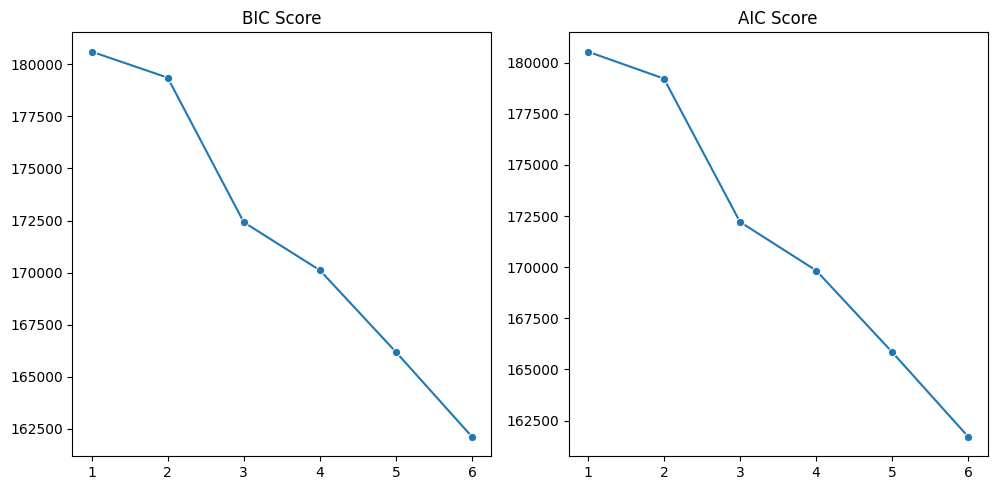

In [ ]:
plt.figure(figsize=(20, 5))

# BIC Plot
plt.subplot(1, 4, 1)
sns.lineplot(x=ks, y=bics, marker='o')
plt.title('BIC Score')

# AIC Plot
plt.subplot(1, 4, 2)
sns.lineplot(x=ks, y=aics, marker='o')
plt.title('AIC Score')


plt.tight_layout()
plt.show()

In [ ]:
sb = np.mean(aics)
tb = np.mean(bics)

In [ ]:
print(f"Mean difference in AIC - BIC compared to relative size: {np.mean([abs(x - aics[idx])/np.mean([sb, tb])for idx,x in enumerate(bics)])}")

Mean difference in AIC - BIC compared to relative size: 0.0010347748171857273


The optimal value for the components in terms of BIC and AIC is 6, log-likelihood also gives the same $K$

In [ ]:
dfr['profile'].value_counts()

4    3279
2    2823
5     709
3     705
0     596
1     583
Name: profile, dtype: int64

3-d version

In [ ]:
! pip install plotly

In [ ]:
dfr.columns

Index(['UMAP1', 'UMAP2', 'UMAP3', 'profile'], dtype='object')

In [ ]:
"""3d version to observe patient profiles"""
import plotly.express as px


dfr.to_csv('Eureca2.0_umapGMM3d.csv')

# Create an interactive 3D scatter plot using plotly
fig = px.scatter_3d(dfr, x='UMAP1', y='UMAP2', z='UMAP3', color='profile', opacity=0.8)

# Update layout for better visibility
fig.update_layout(scene=dict(zaxis=dict(range=[dfr['UMAP3'].min(), dfr['UMAP3'].max()])))

# Show the interactive plot
fig.show()

In [ ]:
cdg =  dfr['profile'].value_counts(normalize=True)
cluster_distribution_gmm = dfr['profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM-3d):")
print(cdg)

Cluster Distribution (GMM-3d):
0    0.198390
5    0.191029
1    0.173433
2    0.172398
3    0.153882
4    0.110868
Name: profile, dtype: float64


There are two weak clusters, 3 and 4, but the latter in particular. Overall the distribution is not very far from uniform.

In [ ]:
cluster_centers_gmm = pd.DataFrame(gmm.means_, columns=['UMAP1', 'UMAP2', 'UMAP3'])
cluster_covariance_gmm = gmm1.covariances_

print("\nCluster Centers 3-d:")
print(cluster_centers_gmm)
print("\nCluster Covariance Matrices (GMM):")
for i, cov_matrix in enumerate(cluster_covariance_gmm):
    print(f"\nCluster {i} Covariance Matrix:")
    print(cov_matrix)


Cluster Centers 3-d:
       UMAP1      UMAP2      UMAP3
0   3.469583  10.541483  -5.155775
1  11.091641  -0.342887   1.355204
2  11.134061  -0.434740  10.043371
3  11.328116  14.599139  10.415795
4  -2.889623  11.752791  10.905645
5  -3.647393  -1.179065   6.626297

Cluster Covariance Matrices (GMM):

Cluster 0 Covariance Matrix:
[[34.11023928  2.06169824 -9.23235437]
 [ 2.06169824 15.8442758   2.114193  ]
 [-9.23235437  2.114193    8.0168645 ]]

Cluster 1 Covariance Matrix:
[[12.76461674 -5.96383468  6.07738594]
 [-5.96383468 22.50746199 27.1355508 ]
 [ 6.07738594 27.1355508  51.25749732]]

Cluster 2 Covariance Matrix:
[[ 26.73776433  11.62522401 -19.6924287 ]
 [ 11.62522401   7.33820574 -10.13428618]
 [-19.6924287  -10.13428618  30.99265473]]

Cluster 3 Covariance Matrix:
[[  2.9330337   -1.60555094   0.59372241]
 [ -1.60555094   8.6553449  -12.61576515]
 [  0.59372241 -12.61576515  31.09964026]]

Cluster 4 Covariance Matrix:
[[  1.38934985  -0.86788498   1.16398343]
 [ -0.86788498 

The covariance matrices are anisotropic for all clusters

2-D version


In [ ]:
# READING DATA
# dfr = pd.read_csv('Eureca2.0_umapGMM.csv')
# dfr.drop('ordered_profile', axis=1, inplace=True)

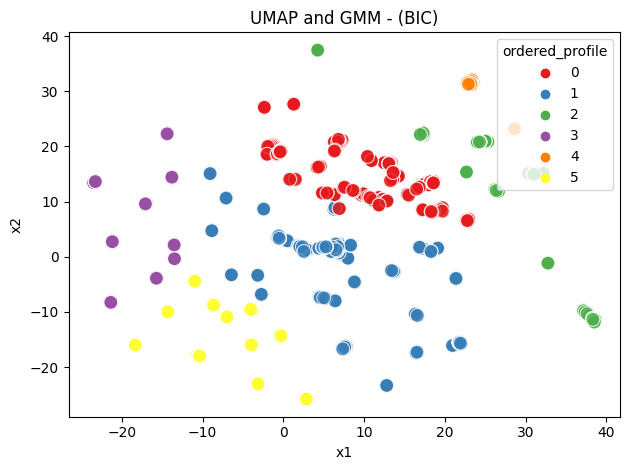

In [ ]:
# 2D

# results without decision regions

cdg=  dfr['profile'].value_counts(normalize=True)
oci = cdg.index
dfr2 = dfr.copy()
# Create ordered_profile2 and ordered_profile3 columns
dfr2['ordered_profile'] = dfr2['profile'].map(dict(zip(oci, range(len(oci)))))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='ordered_profile', data=dfr2, palette="Set1", s=100, alpha=0.8)
plt.title('UMAP and GMM - (BIC)')
plt.xlabel('x1')
plt.ylabel('x2')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


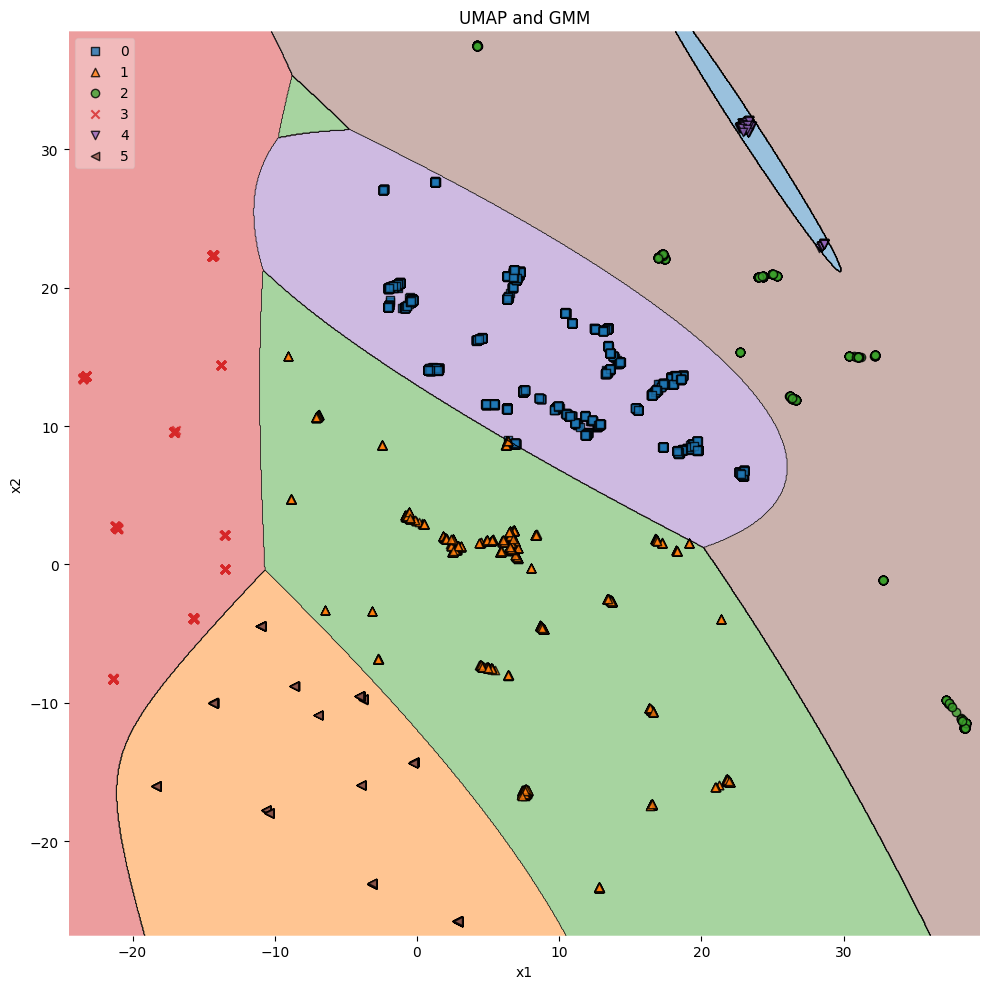

In [ ]:
from mlxtend.plotting import plot_decision_regions
plt.figure(figsize=(10, 10))

# Plot for ordered_profile

plot_decision_regions(embeddings, dfr2['ordered_profile'].values, clf=gmm, legend=2)
plt.title('UMAP and GMM')
plt.xlabel('x1')
plt.ylabel('x2')



# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We now commence by analyzing the results.

In [ ]:
cluster_distribution_gmm = dfr2['ordered_profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM-2d-BIC):")
print(cdg)

Cluster Distribution (GMM-2d-BIC):
4    0.377113
2    0.324669
5    0.081541
3    0.081081
0    0.068545
1    0.067050
Name: profile, dtype: float64


We observe two main profiles which take up way more samples than a uniform distribution, those being 4 and 2, with those samples in excess being missing from the rest of the profiles. Profiles 0 and 3 are close to uniform but profiles 2 and 5 are significantly far from the uniform distribution.

In [ ]:
# 2d
cluster_centers_gmm = pd.DataFrame(gmm.means_, columns=['UMAP1', 'UMAP2'])
cluster_covariance_gmm = gmm.covariances_

print("\nCluster Centers 2-d (GMM-BIC):")
print(cluster_centers_gmm)
print("\nCluster Covariance Matrices (GMM):")
for i, cov_matrix in enumerate(cluster_covariance_gmm):
    print(f"\nCluster {i} Covariance Matrix:")
    print(cov_matrix)


Cluster Centers 2-d (GMM-BIC):
       UMAP1      UMAP2
0  23.668019  30.768374
1  -6.251265 -14.702666
2   6.992505  -2.901725
3 -18.019052   6.690772
4  10.121675  14.138832
5  23.179401  11.739488

Cluster Covariance Matrices (GMM):

Cluster 0 Covariance Matrix:
[[ 2.74312294 -4.26591514]
 [-4.26591514  6.75175878]]

Cluster 1 Covariance Matrix:
[[ 74.42005756 -33.69277669]
 [-33.69277669  51.88256625]]

Cluster 2 Covariance Matrix:
[[ 62.03787717 -47.96172126]
 [-47.96172126 105.04478053]]

Cluster 3 Covariance Matrix:
[[13.93148152  7.33839494]
 [ 7.33839494 96.47226896]]

Cluster 4 Covariance Matrix:
[[ 52.25021771 -22.2709495 ]
 [-22.2709495   22.3441652 ]]

Cluster 5 Covariance Matrix:
[[ 108.18486717 -115.98506801]
 [-115.98506801  189.48385557]]


All of the profiles, have very anisotropic covariance matrices, the clearest example is cluster 3. Cluster 0 however, has close to isotropic covariance matrix, as its eigenvalue ratio is very close to 1 no aplica CHANGE



#### UMAP + KMEANS

Fitting KMeans to 2-d and 3-d data obtained through UMAP based on optimal silhoutte score

In [ ]:
wss = []  # within-cluster sum of squares
sscores = []  # silhouette scores
ks = range(2, 8)  # Adjust the range based on your needs

for n_clusters in ks:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1000)
    kmeans.fit(embeddings)
    labels = kmeans.labels_
    wss.append(kmeans.inertia_)  # Inertia is the WSS
    sscores.append(ss(embeddings, labels))

optimal_k_wss = ks[np.argmin(wss)]

# Find the optimal number of clusters based on silhouette score
optimal_k_silhouette = ks[np.argmax(sscores)]

# KMeans clustering with optimal_k_silhouette
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init=1000)
labels_silhouette = kmeans_silhouette.fit_predict(embeddings)

if np.shape(embeddings)[1] == 2:
    dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
else:
    dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2', 'UMAP3'])


In [ ]:
dfr['profile'] = labels_silhouette

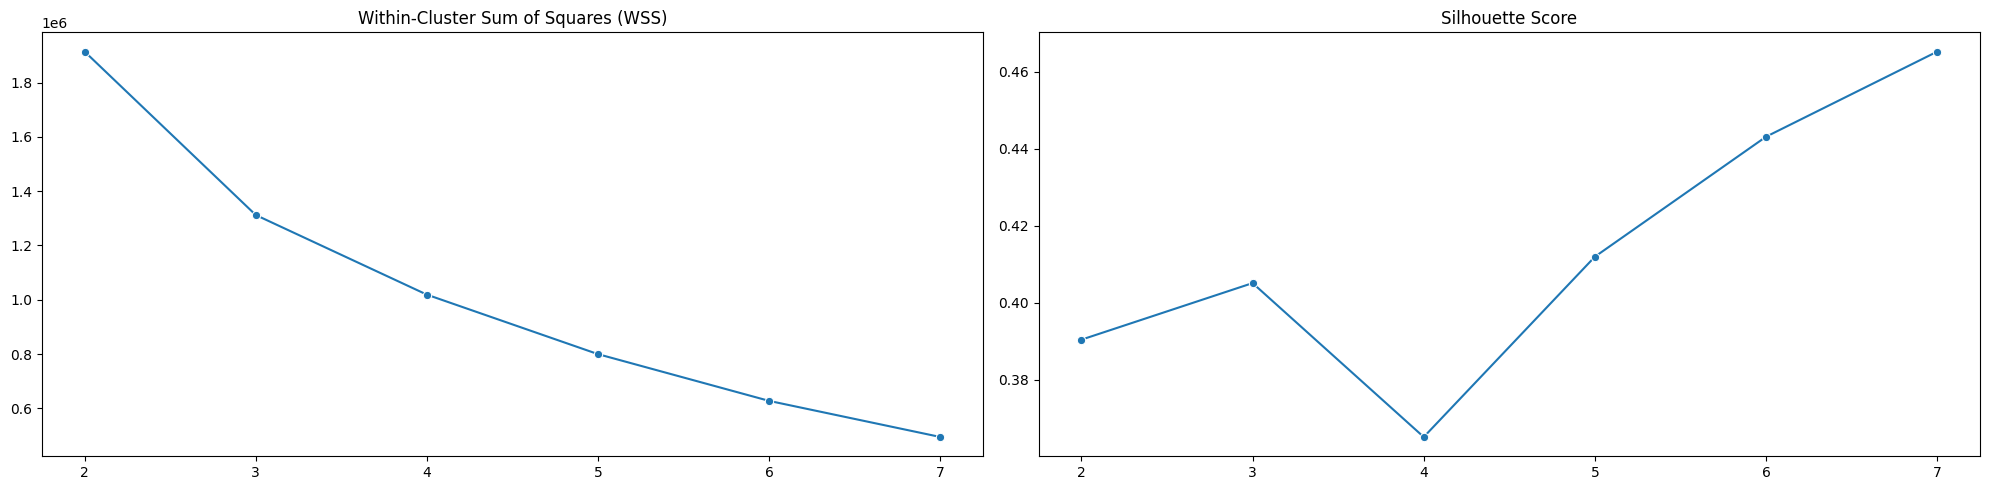

In [ ]:

# Plotting
plt.figure(figsize=(20, 5))

# WSS Plot
plt.subplot(1, 2, 1)
sns.lineplot(x=ks, y=wss, marker='o')
plt.title('Within-Cluster Sum of Squares (WSS)')

# Silhouette Score Plot
plt.subplot(1, 2, 2)
sns.lineplot(x=ks, y=sscores, marker='o')
plt.title('Silhouette Score')


plt.tight_layout()
plt.show()


In [ ]:
# setting clf as gmm, we can observe kmeans groups on gmm with k=3
# setting clf as gmm1, we can osbserve kmeans groups on gmm with k=6
# plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=gmm, legend=2)

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


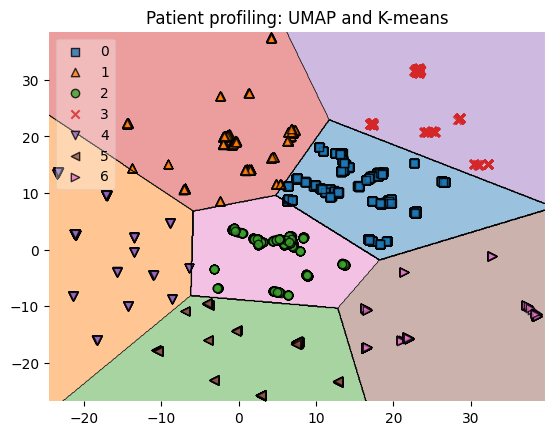

In [ ]:
# KMeans clustering with optimal_k_wss Plot

cdg =  dfr['profile'].value_counts(normalize=True)
ordered_cluster_indices = cdg.index
dfr['ordered_profile'] = dfr['profile'].map(dict(zip(ordered_cluster_indices, range(len(ordered_cluster_indices)))))
plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=kmeans_silhouette, legend=2)
# sns.scatterplot(x=dfr.iloc[:, 0], y=dfr.iloc[:, 1], hue=labels_silhouette, palette='viridis')
plt.title(f'Patient profiling: UMAP and K-means')
plt.show()

As K-means is in fact a mixture model where isotropic variances and uniform component weights are assumed, the result of clustering through KMeans is very somewhat similar.